In [1]:
import pandas as pd
import ast


In [19]:
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)
ratings_df = pd.read_csv('ratings.csv')
credits_df = pd.read_csv('credits.csv')
keywords_df = pd.read_csv('keywords.csv')


In [3]:
movies_df['id'] = movies_df['id'].astype(str)
credits_df['id'] = credits_df['id'].astype(str)
keywords_df['id'] = keywords_df['id'].astype(str)

In [4]:
# Extract cast and crew
credits_df['cast'] = credits_df['cast'].apply(
    lambda x: [i['name'] for i in ast.literal_eval(x)] if isinstance(x, str) else [])
credits_df['crew_roles'] = credits_df['crew'].apply(
    lambda x: {i['job']: i['name'] for i in ast.literal_eval(x) if i['job'] in ['Director', 'Producer']}
    if isinstance(x, str) else {})


In [5]:
# Extract keywords
keywords_df['keywords'] = keywords_df['keywords'].apply(
    lambda x: [i['name'] for i in ast.literal_eval(x)] if isinstance(x, str) else [])

In [6]:
# Flatten genres
movies_df['genres'] = movies_df['genres'].apply(
    lambda x: ', '.join([i['name'] for i in ast.literal_eval(x)]) if isinstance(x, str) else '')


In [7]:
# Flatten spoken languages
movies_df['spoken_languages'] = movies_df['spoken_languages'].apply(
    lambda x: ', '.join([i['name'] for i in ast.literal_eval(x)]) if isinstance(x, str) else '')


In [8]:
# Calculate profit
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce').fillna(0)
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce').fillna(0)
movies_df['profit'] = movies_df['revenue'] - movies_df['budget']

In [9]:
# Merge datasets
final_df = movies_df.merge(credits_df[['id', 'cast', 'crew_roles']], on='id', how='left')
final_df = final_df.merge(keywords_df[['id', 'keywords']], on='id', how='left')

In [10]:
# Add a popularity column
final_df['popularity'] = final_df['vote_average'] * final_df['vote_count']

In [14]:
# Preview the updated dataset
print(final_df[['id', 'title', 'genres', 'cast', 'crew_roles', 'keywords', 'profit', 'popularity']])


           id                        title                      genres  \
0         862                    Toy Story   Animation, Comedy, Family   
1        8844                      Jumanji  Adventure, Fantasy, Family   
2       15602             Grumpier Old Men             Romance, Comedy   
3       31357            Waiting to Exhale      Comedy, Drama, Romance   
4       11862  Father of the Bride Part II                      Comedy   
...       ...                          ...                         ...   
46627  439050                       Subdue               Drama, Family   
46628  111109          Century of Birthing                       Drama   
46629   67758                     Betrayal     Action, Drama, Thriller   
46630  227506             Satan Triumphant                               
46631  461257                     Queerama                               

                                                    cast  \
0      [Tom Hanks, Tim Allen, Don Rickles, Jim Varn

In [15]:
# Preview the updated dataset
print(final_df[['id', 'title', 'genres', 'cast', 'crew_roles', 'keywords', 'profit', 'popularity']].tail())


           id                title                   genres  \
46627  439050               Subdue            Drama, Family   
46628  111109  Century of Birthing                    Drama   
46629   67758             Betrayal  Action, Drama, Thriller   
46630  227506     Satan Triumphant                            
46631  461257             Queerama                            

                                                    cast  \
46627        [Leila Hatami, Kourosh Tahami, Elham Korda]   
46628  [Angel Aquino, Perry Dizon, Hazel Orencio, Joe...   
46629  [Erika Eleniak, Adam Baldwin, Julie du Page, J...   
46630  [Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...   
46631                                                 []   

                                              crew_roles  \
46627  {'Director': 'Hamid Nematollah', 'Producer': '...   
46628                           {'Director': 'Lav Diaz'}   
46629                     {'Director': 'Mark L. Lester'}   
46630  {'Director': 

In [16]:
# Preview the updated dataset
print(final_df[['id', 'title', 'genres', 'cast', 'crew_roles', 'keywords', 'profit', 'popularity']].head())

      id                        title                      genres  \
0    862                    Toy Story   Animation, Comedy, Family   
1   8844                      Jumanji  Adventure, Fantasy, Family   
2  15602             Grumpier Old Men             Romance, Comedy   
3  31357            Waiting to Exhale      Comedy, Drama, Romance   
4  11862  Father of the Bride Part II                      Comedy   

                                                cast  \
0  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...   
1  [Robin Williams, Jonathan Hyde, Kirsten Dunst,...   
2  [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...   
3  [Whitney Houston, Angela Bassett, Loretta Devi...   
4  [Steve Martin, Diane Keaton, Martin Short, Kim...   

                                          crew_roles  \
0  {'Director': 'John Lasseter', 'Producer': 'Ral...   
1  {'Director': 'Joe Johnston', 'Producer': 'Will...   
2                      {'Director': 'Howard Deutch'}   
3  {'Director': 'Forest 

In [24]:
# Save to a new CSV for EDA
final_df.to_csv('enhanced_movies_dataset.csv', index=False)


In [44]:
# Ensure 'id' columns are numeric
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
credits_df['id'] = pd.to_numeric(credits_df['id'], errors='coerce')
keywords_df['id'] = pd.to_numeric(keywords_df['id'], errors='coerce')

# Merge datasets
df = pd.merge(movies_df, credits_df, on='id', how='inner')
df = pd.merge(df, keywords_df, on='id', how='inner')

# Process 'genres' to extract names
def extract_genres(genres):
    try:
        genres_list = ast.literal_eval(genres)
        return ', '.join([genre['name'] for genre in genres_list])
    except (ValueError, TypeError):
        return genres

df['genres'] = df['genres'].apply(extract_genres)

# Process 'cast' to extract names
def extract_cast(cast):
    try:
        cast_list = ast.literal_eval(cast)
        return ', '.join([actor['name'] for actor in cast_list[:5]])  # Top 5 cast members
    except (ValueError, TypeError):
        return cast

df['cast'] = df['cast'].apply(extract_cast)

# Process 'crew' to extract roles
def extract_crew_roles(crew):
    try:
        crew_list = ast.literal_eval(crew)
        crew_roles = {person['job']: person['name'] for person in crew_list if 'job' in person and 'name' in person}
        return crew_roles
    except (ValueError, TypeError):
        return crew

df['crew_roles'] = df['crew'].apply(extract_crew_roles)

# Process 'keywords' to extract names
def extract_keywords(keywords):
    try:
        keywords_list = ast.literal_eval(keywords)
        return ', '.join([keyword['name'] for keyword in keywords_list])
    except (ValueError, TypeError):
        return keywords

df['keywords'] = df['keywords'].apply(extract_keywords)

# Select and rename columns for final output
df = df[['id', 'title', 'genres', 'cast', 'crew_roles', 'keywords', 'revenue', 'popularity']]
df.rename(columns={'revenue': 'profit'}, inplace=True)

# Display the final DataFrame
print(df.head())

        id                        title                      genres  \
0    862.0                    Toy Story   Animation, Comedy, Family   
1   8844.0                      Jumanji  Adventure, Fantasy, Family   
2  15602.0             Grumpier Old Men             Romance, Comedy   
3  31357.0            Waiting to Exhale      Comedy, Drama, Romance   
4  11862.0  Father of the Bride Part II                      Comedy   

                                                cast  \
0  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
1  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...   
2  Walter Matthau, Jack Lemmon, Ann-Margret, Soph...   
3  Whitney Houston, Angela Bassett, Loretta Devin...   
4  Steve Martin, Diane Keaton, Martin Short, Kimb...   

                                          crew_roles  \
0  {'Director': 'John Lasseter', 'Screenplay': 'A...   
1  {'Executive Producer': 'Robert W. Cort', 'Scre...   
2  {'Director': 'Howard Deutch', 'Characters': 'M...   
3  {'Directo

In [45]:
# Basic information about the dataset
print(df.info())

# Check the first few rows
print(df.head())

# Summary statistics for numeric columns
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          46628 non-null  float64
 1   title       46624 non-null  object 
 2   genres      46628 non-null  object 
 3   cast        46628 non-null  object 
 4   crew_roles  46628 non-null  object 
 5   keywords    46628 non-null  object 
 6   profit      46624 non-null  float64
 7   popularity  46624 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.8+ MB
None
        id                        title                      genres  \
0    862.0                    Toy Story   Animation, Comedy, Family   
1   8844.0                      Jumanji  Adventure, Fantasy, Family   
2  15602.0             Grumpier Old Men             Romance, Comedy   
3  31357.0            Waiting to Exhale      Comedy, Drama, Romance   
4  11862.0  Father of the Bride Part II                      Comedy   

In [46]:
# Check for missing values
print(df.isnull().sum())


id            0
title         4
genres        0
cast          0
crew_roles    0
keywords      0
profit        4
popularity    4
dtype: int64


In [47]:
# Unique values in 'genres'
print(df['genres'].unique())

# Unique values in 'title'
print(df['title'].nunique())  # Count of unique titles


['Animation, Comedy, Family' 'Adventure, Fantasy, Family'
 'Romance, Comedy' ... 'Crime, Comedy, Action, Family'
 'Action, Mystery, Thriller, Horror' 'Family, Animation, Romance, Comedy']
42276


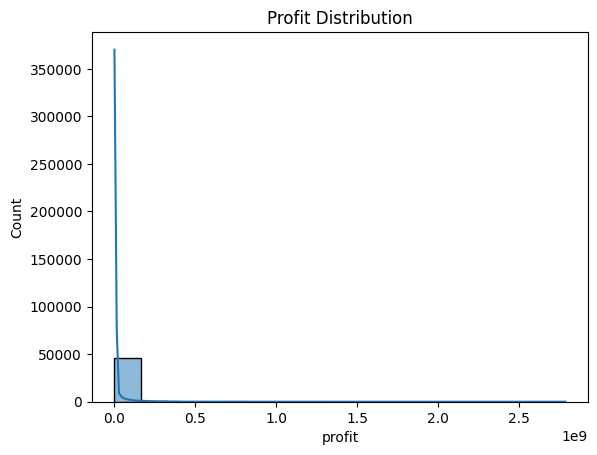

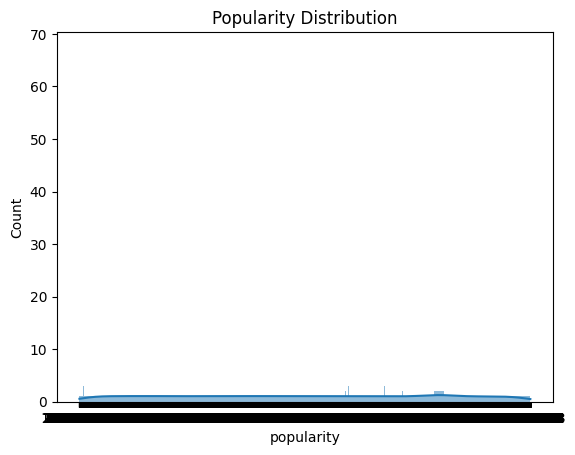

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of 'profit'
sns.histplot(df['profit'], kde=True)
plt.title("Profit Distribution")
plt.show()

# Distribution of 'popularity'
sns.histplot(df['popularity'], kde=True)
plt.title("Popularity Distribution")
plt.show()



              profit  popularity
profit      1.000000    0.505914
popularity  0.505914    1.000000


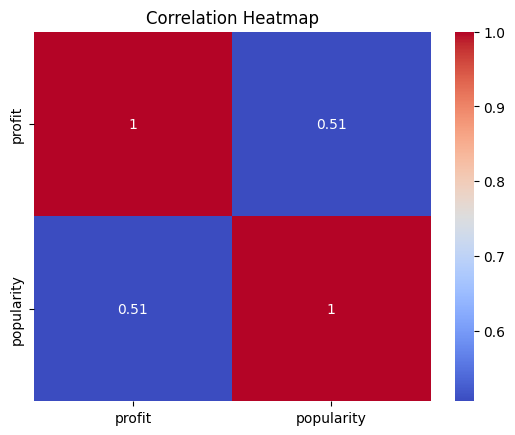

In [49]:
# Correlation between numeric columns
correlation = df[['profit', 'popularity']].corr()
print(correlation)

# Heatmap for correlation
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


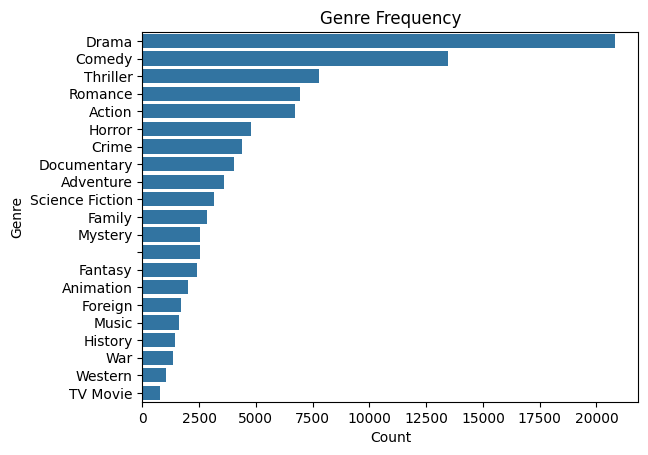

In [51]:
# Count the frequency of each genre
from collections import Counter

# Flatten the list of genres
all_genres = [genre for sublist in df['genres'].str.split(', ') for genre in sublist]
genre_counts = Counter(all_genres)

# Convert to DataFrame for visualization
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot genre frequency
sns.barplot(x='Count', y='Genre', data=genre_df)
plt.title("Genre Frequency")
plt.show()



In [52]:
# Top 5 movies by profit
top_profit_movies = df.sort_values(by='profit', ascending=False).head(5)
print(top_profit_movies[['title', 'profit']])


                              title        profit
14644                        Avatar  2.787965e+09
26720  Star Wars: The Force Awakens  2.068224e+09
1651                        Titanic  1.845034e+09
17934                  The Avengers  1.519558e+09
25235                Jurassic World  1.513529e+09


In [53]:
# Flatten the list of cast members
all_cast = [actor for sublist in df['cast'].str.strip('[]').str.replace("'", "").str.split(', ') for actor in sublist]
cast_counts = Counter(all_cast)

# Convert to DataFrame
cast_df = pd.DataFrame(cast_counts.items(), columns=['Actor', 'Count']).sort_values(by='Count', ascending=False)

# Top 10 actors
print(cast_df.head(10))


                  Actor  Count
616                       2491
388                 Jr.    120
2863         John Wayne    107
510         Jackie Chan    101
5075    Christopher Lee     98
26       Robert De Niro     98
1395   Gérard Depardieu     97
3637      Michael Caine     96
921   Donald Sutherland     84
326       Harvey Keitel     84


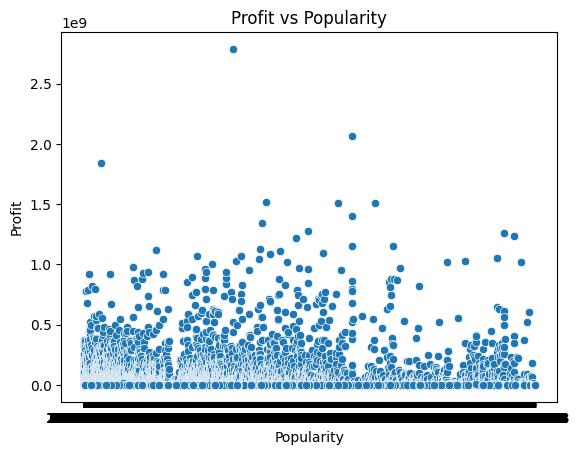

In [55]:
# Scatter plot for profit vs popularity
sns.scatterplot(x='popularity', y='profit', data=df)
plt.title("Profit vs Popularity")
plt.xlabel("Popularity")
plt.ylabel("Profit")
plt.show()
